In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

info_type = "hidden_states"
layer = "31"
file_name = "ablation_pca.csv"

humaneval_file_path = os.path.join(
    "humaneval", "codellama-13b-Instruct", info_type, layer, file_name
)
mbpp_file_path = os.path.join(
    "mbpp", "codellama-13b-Instruct", info_type, layer, file_name
)
code_search_net_java_file_path = os.path.join(
    "code_search_net_java",
    "codellama-13b-Instruct_with_semantic",
    info_type,
    layer,
    file_name,
)
tl_code_sum_file_path = os.path.join(
    "tl_code_sum", "codellama-13b-Instruct_with_semantic", info_type, layer, file_name
)

truthful_qa_file_path = os.path.join("truthful_qa", "llama2_7B_with_semantics", info_type, layer, file_name)
sst2_file_path = os.path.join("sst2", "llama2_7B", info_type, layer, file_name)
advglue_file_path = os.path.join("advglue++", "llama2_7B", info_type, layer, file_name)

In [2]:
# def drop_column(file_path, column):
#     df = pd.read_csv(file_path)
#     df = df.drop(columns=[column])
#     df.to_csv(file_path, index=False)

# drop_column(truthful_qa_file_path, 'transition_matrix_list')
# drop_column(sst2_file_path, 'transition_matrix_list')
# drop_column(advglue_file_path, 'transition_matrix_list')
# drop_column(humaneval_file_path, 'transition_matrix_list')
# drop_column(mbpp_file_path, 'transition_matrix_list')
# drop_column(code_search_net_java_file_path, 'transition_matrix_list')
# drop_column(tl_code_sum_file_path, 'transition_matrix_list')


In [3]:

def get_df(file_path):
    df = pd.read_csv(file_path)
    split_settings = df['settings'].str.split('_', expand=True)
    df['abstract_method'] = split_settings[0]
    df['abstract_state_num'] = split_settings[1]
    df['PCA_dim'] = split_settings[2]
    df['model_type'] = split_settings[3]
    df['hmm_component'] = split_settings[4]
    df['grid_history_dependency'] = split_settings[5]

    df['PCA_dim'] = pd.to_numeric(df['PCA_dim'], errors='coerce')

    # Replace inf/-inf with 0
    df.replace([np.inf, -np.inf], 0, inplace=True)

    
    return df

df_humaneval = get_df(humaneval_file_path)
df_mbpp = get_df(mbpp_file_path)
df_code_search_net_java = get_df(code_search_net_java_file_path)
df_tl_code_sum = get_df(tl_code_sum_file_path)

df_truthful_qa = get_df(truthful_qa_file_path)

df_sst2 = get_df(sst2_file_path)
df_advglue = get_df(advglue_file_path)


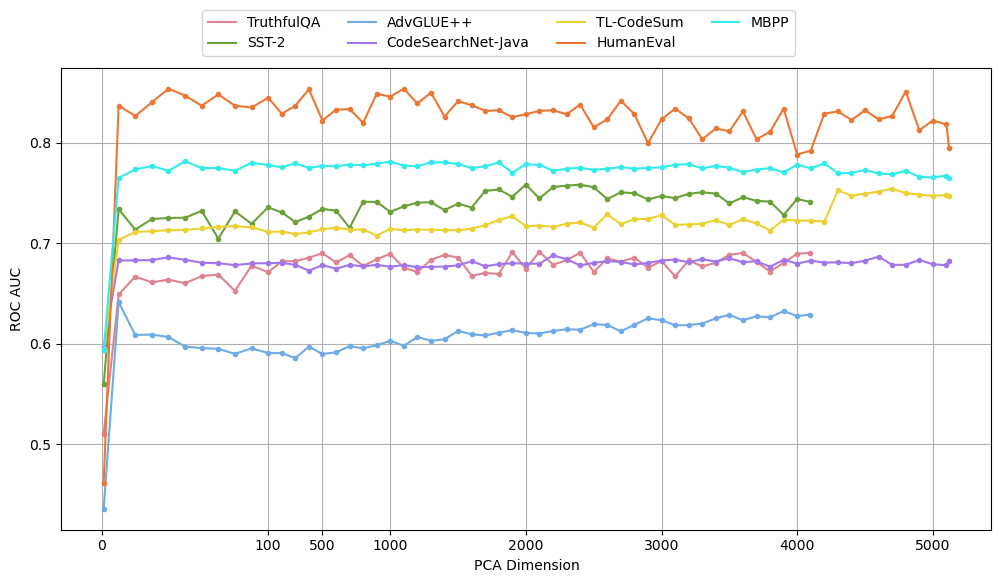

In [4]:
# Aggregating data as per your instructions
pca_stats = {
    'TruthfulQA': df_truthful_qa.groupby('PCA_dim')['aucroc'].agg(['mean', 'max', 'min']),
    'SST-2': df_sst2.groupby('PCA_dim')['aucroc'].agg(['mean', 'max', 'min']),
    'AdvGLUE++': df_advglue.groupby('PCA_dim')['aucroc'].agg(['mean', 'max', 'min']),
    'CodeSearchNet-Java': df_code_search_net_java.groupby('PCA_dim')['aucroc'].agg(['mean', 'max', 'min']),
    'TL-CodeSum': df_tl_code_sum.groupby('PCA_dim')['aucroc'].agg(['mean', 'max', 'min']),
    'HumanEval': df_humaneval.groupby('PCA_dim')['aucroc'].agg(['mean', 'max', 'min']),
    'MBPP': df_mbpp.groupby('PCA_dim')['aucroc'].agg(['mean', 'max', 'min']),
    
}

dataset_colors = {
    'TruthfulQA': '#de8390',  # Pink
    'SST-2': '#6ba138',  # Green
    'AdvGLUE++': '#6fabe5',  # Blue
    'CodeSearchNet-Java': '#a276eb',  # Purple, new color
    'TL-CodeSum': '#ebd234',  # Yellow, new color
    'HumanEval': '#eb7734',  # Orange, new color
    'MBPP': '#34ebeb',  # Cyan, new color
}

def map_to_segments(x, breakpoint=100, max_value=5000, first_segment_fraction=1/5):
    """
    Maps a value 'x' from 0-5000 to a new scale where the range 0-100 occupies
    a specified fraction of the axis length, and the range 100-5000 occupies the rest.
    
    :param x: Original x-value.
    :param breakpoint: The value at which the scale changes, typically 100.
    :param max_value: The maximum value in the original scale, typically 5000.
    :param first_segment_fraction: The fraction of the axis length the first segment (0-100) should occupy.
    :return: New x-value mapped to the custom scale.
    """
    if x <= breakpoint:
        # Scale the first segment (0-100) to occupy the specified fraction of the axis
        return x * first_segment_fraction / breakpoint
    else:
        # Scale the second segment (100-5000) to occupy the remaining part of the axis
        remaining_fraction = 1 - first_segment_fraction
        return first_segment_fraction + (x - breakpoint) * remaining_fraction / (max_value - breakpoint)

# Plotting
plt.figure(figsize=(12, 6))

for dataset, stats in pca_stats.items():
    # Apply the custom scaling to PCA_dim values
    scaled_x = [map_to_segments(x) for x in stats.index]
    
    # Plot using scaled PCA_dim values
    plt.plot(scaled_x, stats['mean'], color=dataset_colors[dataset], label=dataset, marker='o', markersize=3)

# Customizing the plot
plt.xlabel('PCA Dimension')
plt.ylabel('ROC AUC')

# Adjust these based on your dataset's range and the output of your scaling function
tick_positions = [map_to_segments(x) for x in [0, 100, 500, 1000, 2000, 3000, 4000, 5000]]
tick_labels = ['0', '100', '500', '1000', '2000', '3000', '4000', '5000']
plt.xticks(tick_positions, tick_labels)

plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.47, 1.14), markerscale=0)
plt.grid(True)
plt.savefig('plot/ablation_pca.pdf')
plt.show()


In [5]:
# def line_plot(stats, xlim):
#     plt.figure(figsize=(20, 4))

#     plt.plot(stats.index, stats['mean'], label='Mean AUC ROC', marker='o')
#     plt.plot(stats.index, stats['max'], label='Max AUC ROC', marker='o')
#     plt.plot(stats.index, stats['min'], label='Min AUC ROC', marker='o')

#     plt.xlim(0, xlim)

#     plt.title('AUC ROC vs PCA Dimension')
#     plt.xlabel('PCA Dimension')
#     plt.ylabel('AUC ROC Score')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

    
        

